In [1]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

import numpy as np
from math import sqrt

def display_img(img):
    ncols, nrows = 1, 1
    scale        = 14
    fig   = plt.figure(figsize = (ncols * scale, nrows * scale))
    gspec = fig.add_gridspec( nrows, ncols )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    ax = ax_list[0]

    vmin = np.mean(img) - 0 * img.std()
    vmax = np.mean(img) + 4 * img.std()
    im = ax.imshow(img, vmin = vmin, vmax = vmax)


def display_patches(patches):
    N, H, W = patches.shape
    ndiv = int(sqrt(N))
    ncols = ndiv
    nrows = ndiv
    fig   = plt.figure(figsize = (18,18))
    gspec = fig.add_gridspec( nrows, ncols, )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    vmin = np.mean(patches) - 0 * patches.std()
    vmax = np.mean(patches) + 4 * patches.std()
    for row in range(nrows):
        for col in range(ncols):
            idx = col + ncols * row
            ax = ax_list[idx]
            # data_viz = patches[row][col]
            data_viz = patches[idx]
            ax.imshow(data_viz, interpolation = 'none', vmin = vmin, vmax = vmax)

    # Apply style...
    for ax in ax_list:
        ax.set_xticks([])
        ax.set_yticks([])

        # Hide the frame box
        ax.spines['top'   ].set_visible(False)
        ax.spines['right' ].set_visible(False)
        ax.spines['left'  ].set_visible(False)
        ax.spines['bottom'].set_visible(False)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from safetensors.torch import load_file

file_safetensor = "../proj.peaknet/peaknet10k/mfxl1027522_highpH_DTT_red_slow.ios_1p0.0606.safetensors"

data = load_file(file_safetensor)

In [4]:
data["image"].shape

torch.Size([10, 1, 1667, 1665])

In [5]:
class Pad:
    def __init__(self, H, W):
        self.H = H
        self.W = W


    def calc_pad_width(self, img):
        H = self.H
        W = self.W
        _, _, H_img, W_img = img.shape

        dH_padded = max(H - H_img, 0)
        dW_padded = max(W - W_img, 0)

        pad_width = (
            dW_padded // 2, dW_padded - dW_padded // 2,    # -1 dimension (left, right)
            dH_padded // 2, dH_padded - dH_padded // 2,    # -2 dimension (top, bottom)
        )

        return pad_width


    def __call__(self, img):
        pad_width  = self.calc_pad_width(img)
        img_padded = F.pad(img, pad_width, 'constant', 0)

        return img_padded

In [6]:
from math import ceil

In [7]:
# Assume img is your input image tensor of shape (B, C, H, W)
imgs = data["image"].to(torch.float32)

B, C, H, W = imgs.shape

patch_size = 244
stride = 244 // 2

H_padded, W_padded = patch_size * ceil(H / patch_size), patch_size * ceil(W / patch_size)

padder = Pad(H_padded, W_padded)
imgs_padded = padder(imgs)

# Using unfold to create patches
patches = F.unfold(imgs_padded, kernel_size=(patch_size, patch_size), stride=stride)
print(patches.shape)

patches = patches.view(B, patch_size, patch_size, -1)
print(patches.shape)

# Reshape and permute to get the physical layout of the patches
patches = patches.permute(0, 3, 1, 2).contiguous()
print(patches.shape)# (num_patches, channels, patch_height, patch_width)

torch.Size([10, 59536, 169])
torch.Size([10, 244, 244, 169])
torch.Size([10, 169, 244, 244])


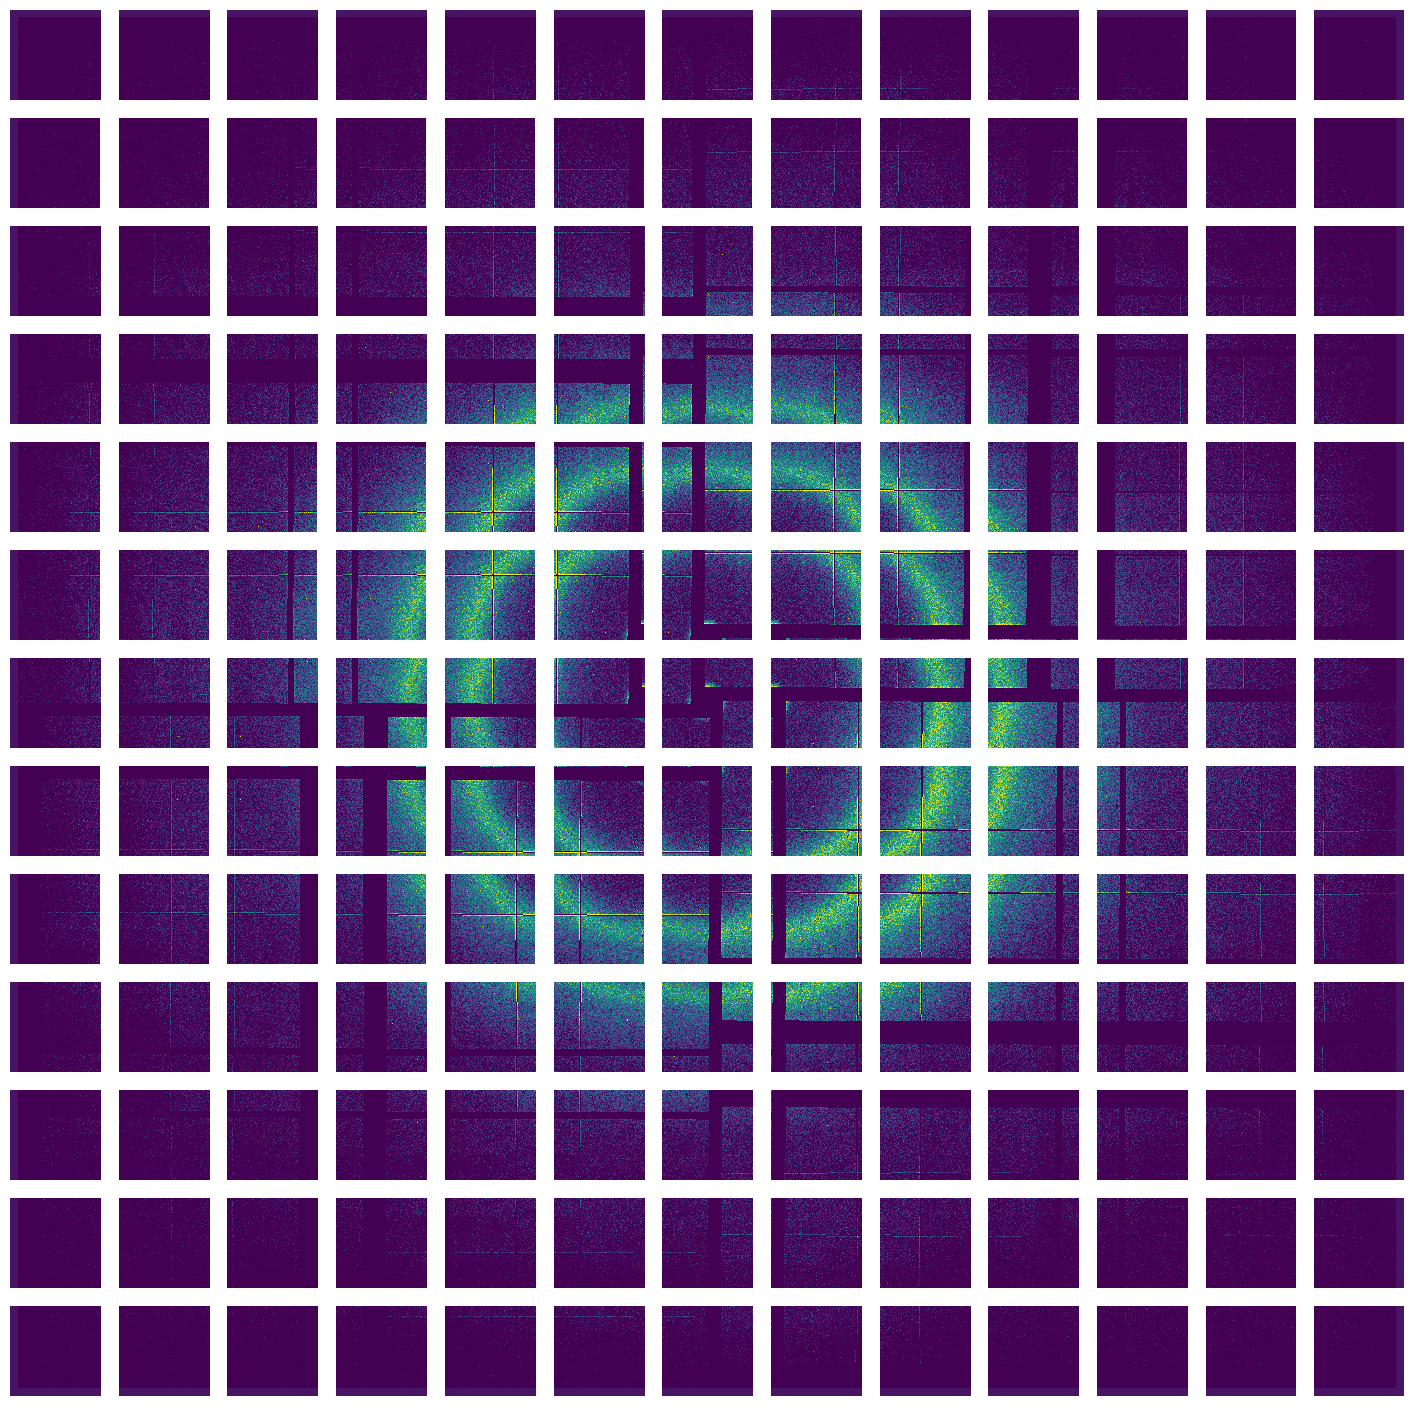

In [8]:
display_patches(patches[0].numpy())

In [9]:
patches.shape

torch.Size([10, 169, 244, 244])

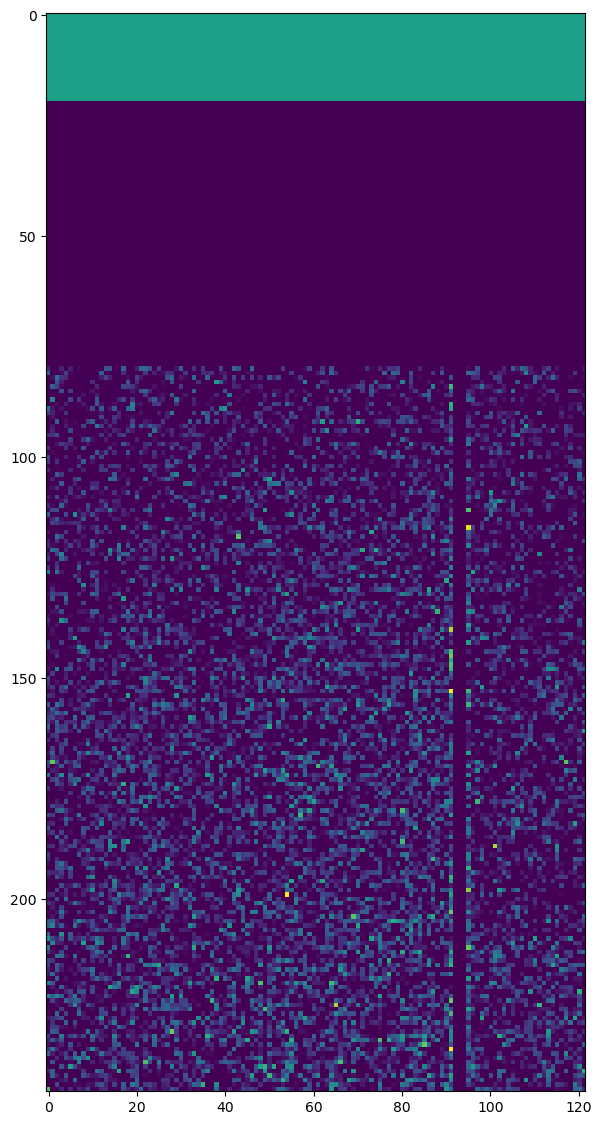

In [10]:
display_img(patches[0, 0, :, 244//2:].numpy())

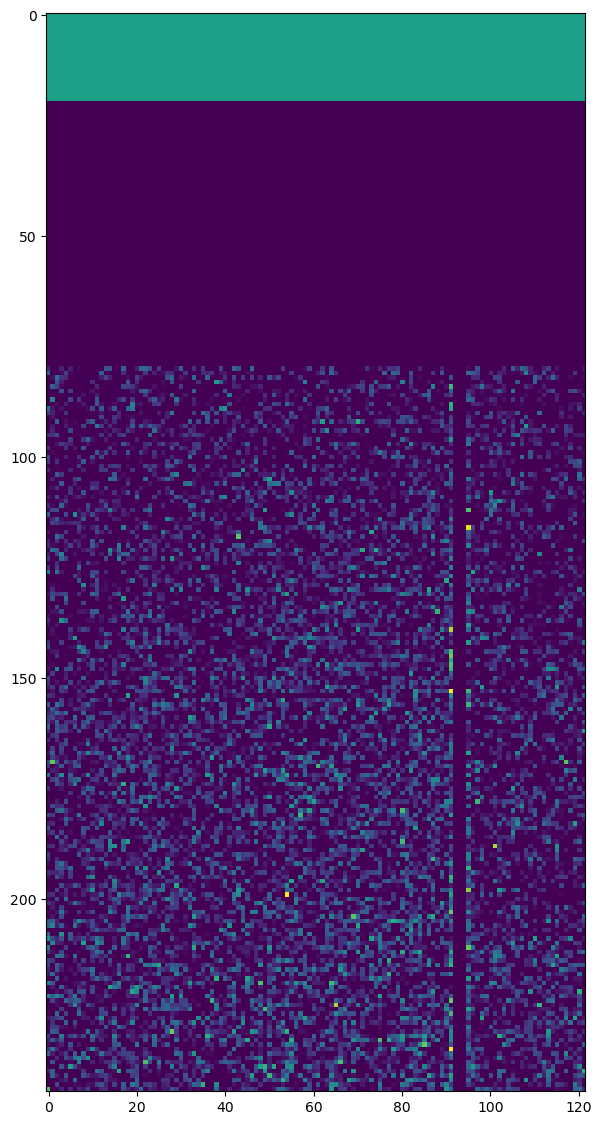

In [11]:
display_img(patches[0, 1, :, :244//2].numpy())

In [12]:
torch.equal(patches[0, 0, :, 244//2:], patches[0, 1, :, :244//2])

True

In [13]:
import sys; sys.exit(1)

SystemExit: 1

/sdf/data/lcls/ds/prj/prjcwang31/results/conda/ana-4.0.58-py3-ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
